<a href="https://colab.research.google.com/github/lIIIIllIIllll/AI_lab/blob/main/Week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning for Computer Vision Tutorial**

In [6]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

**Load Data**

In [7]:
# === 데이터 준비 셀 (네 코드 실행 전에 딱 1번만 실행) ===
import os, zipfile, shutil
from google.colab import files

# 1) ZIP 업로드
uploaded = files.upload()
zip_name = next(iter(uploaded))  # 업로드한 ZIP 파일명

# 2) 압축 해제
extract_root = '/content'
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_root)

# 3) ZIP 내부에서 train/val을 담은 루트 자동 탐색
def find_split_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        lower = {d.lower() for d in dirnames}
        if {'train','val'}.issubset(lower):
            return dirpath
    return None

split_root = find_split_root(extract_root)
if split_root is None:
    raise RuntimeError("ZIP 안에서 'train'과 'val' 폴더를 찾지 못했습니다. "
                       "구조가 train/val/<class>/... 형태인지 확인하세요.")

# 4) 튜토리얼이 기대하는 경로로 연결: data/hymenoptera_data
target_dir = '/content/data/hymenoptera_data'
os.makedirs('/content/data', exist_ok=True)

# 기존 대상 경로 정리
if os.path.islink(target_dir) or os.path.exists(target_dir):
    try:
        if os.path.islink(target_dir):
            os.unlink(target_dir)
        else:
            shutil.rmtree(target_dir)
    except Exception:
        pass

# 심볼릭 링크가 되면 링크, 안 되면 복사
try:
    os.symlink(split_root, target_dir, target_is_directory=True)
    print(f"[OK] Linked {split_root} -> {target_dir}")
except OSError:
    shutil.copytree(split_root, target_dir)
    print(f"[OK] Copied {split_root} -> {target_dir}")

# 5) 확인(선택)
print("train classes:", os.listdir(os.path.join(target_dir, 'train'))[:5])
print("val classes:", os.listdir(os.path.join(target_dir, 'val'))[:5])


Saving hymenoptera_data.zip to hymenoptera_data.zip
[OK] Linked /content/hymenoptera_data -> /content/data/hymenoptera_data
train classes: ['ants', 'bees']
val classes: ['ants', 'bees']


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Visualize a few images**

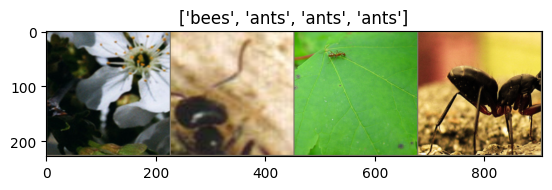

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Training the model**

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

**Visualizing the model predictions**

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Finetuning the ConvNet**

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


**Train and evaluate**

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5277 Acc: 0.7336
val Loss: 0.2354 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.7024 Acc: 0.7582
val Loss: 0.2774 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5167 Acc: 0.7705
val Loss: 0.3565 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5833 Acc: 0.7582
val Loss: 0.5065 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.5308 Acc: 0.8115
val Loss: 0.6138 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.4669 Acc: 0.8156
val Loss: 0.8755 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.5504 Acc: 0.7869
val Loss: 0.5380 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4533 Acc: 0.8156
val Loss: 0.3300 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.4277 Acc: 0.7992
val Loss: 0.3040 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.4007 Acc: 0.8033
val Loss: 0.2731 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3364 Acc: 0.8852
val Loss: 0.2596 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3095 Acc: 0.8811
val Loss: 0.2577 Acc: 0.9085

Ep

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


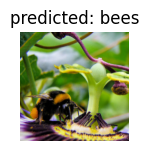

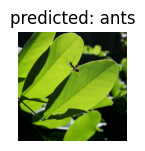

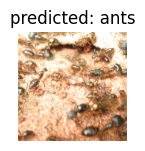

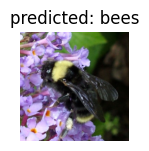

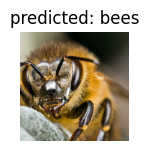

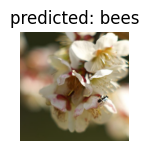

In [17]:
visualize_model(model_ft)